In [1]:
#XGboost Only:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
import imageio
import os

In [2]:
df=pd.read_csv("mid-gas-2017-2019.csv",index_col=[0], parse_dates=[0])
df.head(3)

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas
datetime,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832


In [3]:
df_INDO=pd.read_csv('INDO-2017-2019.csv',index_col=[0],parse_dates=[0])
df_INDO.head(3)

,Settlement_Period,INDO
datetime,,
2017-01-01 00:00:00,1,27239
2017-01-01 00:30:00,2,27814
2017-01-01 01:00:00,3,27453


In [4]:
df=pd.merge(df,df_INDO['INDO'], how='inner', left_index=True, right_index=True)

In [5]:
df.head(3)

,Price,Volume,Settlement Period,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SAP,EU_ETS,Gas,INDO
datetime,,,,,,,,,,,,,,,
2017-01-01 00:00:00,44.90,505.00,1,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27239
2017-01-01 00:30:00,47.13,559.15,2,0.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27814
2017-01-01 01:00:00,45.62,649.35,3,1.0,Sun,1.0,Jan,2017.0,1.0,1.0,52.0,16.95,1.033832,21.294832,27453


In [12]:
#Splitting the data:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

def limit(data, frm, to):
    return data[(data.index>=frm)&(data.index<to)]

In [10]:
df.sort_index(inplace=True)

In [11]:
t = df.Price.copy()
t = t.drop(t.index[t.index.duplicated()])
freq_index = pd.date_range(start=t.index[0], end=t.index[-1], freq='30T')
constructed = pd.Series(index=freq_index, name='Price')
constructed.update(t)
constructed.interpolate(inplace=True)

In [13]:
train = limit(constructed, '2017-01-01', '2019-06-15')
test  = limit(constructed, '2019-06-15', '2019-07-01')
train.shape, test.shape

((42960,), (768,))

In [21]:
#for INDO data
i = df.INDO.copy()
i = i.drop(i.index[i.index.duplicated()])
freq_index = pd.date_range(start=i.index[0], end=i.index[-1], freq='30T')
constructed_i = pd.Series(index=freq_index, name='INDO')
constructed_i.update(i)
constructed_i.interpolate(inplace=True)

In [22]:
train_indo = limit(constructed_i, '2019-01-01', '2019-06-15')
test_indo  = limit(constructed_i, '2019-06-15', '2019-07-01')
print(train_indo.shape)
print(test_indo.shape)

(7920,)
(768,)


In [23]:
df_train=df[df.index.isin(train.index)].copy()
df_test=df[df.index.isin(test.index)].copy()
df_train.shape,df_test.shape

((42575, 15), (768, 15))

In [9]:
#split_date = '15-Jun-2019 00:00'
#df_train = df.loc[df.index <= split_date].copy()
#df_test = df.loc[df.index > split_date].copy()

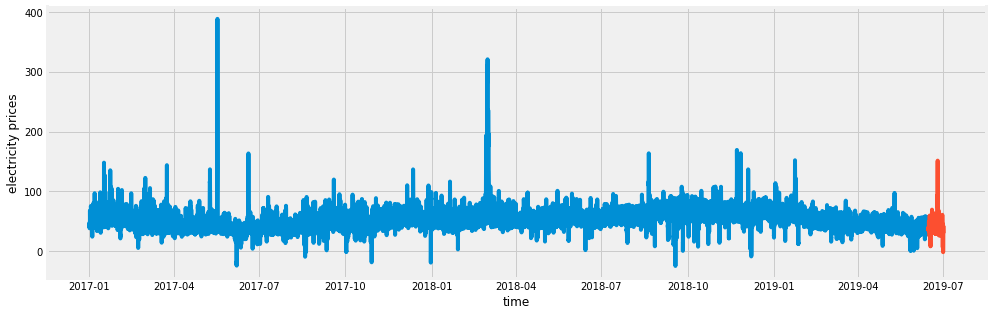

In [18]:
plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('electricity prices')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [29]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear', 'Gas', 'INDO']]
    
    return X


In [30]:
X_train, y_train = create_features(df_train), df_train['Price']
X_test, y_test   = create_features(df_test), df_test['Price']

X_train.shape, y_train.shape, X_test.shape,y_test.shape

((42575, 10), (42575,), (768, 10), (768,))

In [31]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

[20:47:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

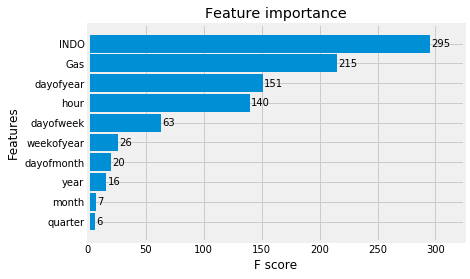

In [32]:
xgb.plot_importance(reg, height=0.9)

In [33]:
forecast_xgb= reg.predict(X_test)


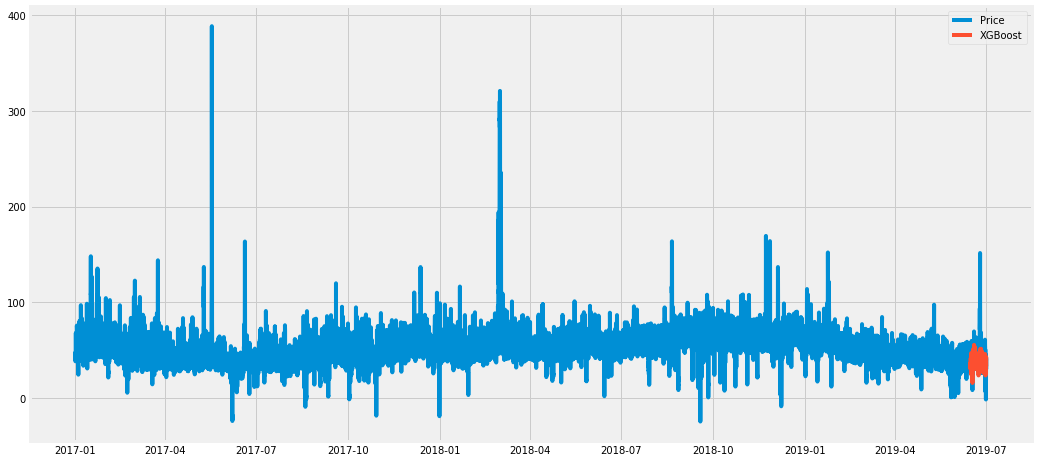

In [34]:
plt.figure(figsize=(16,8))
plt.plot(pd.concat([train,test]))
plt.plot(test.index, forecast_xgb, label='XGBoost')
plt.legend()

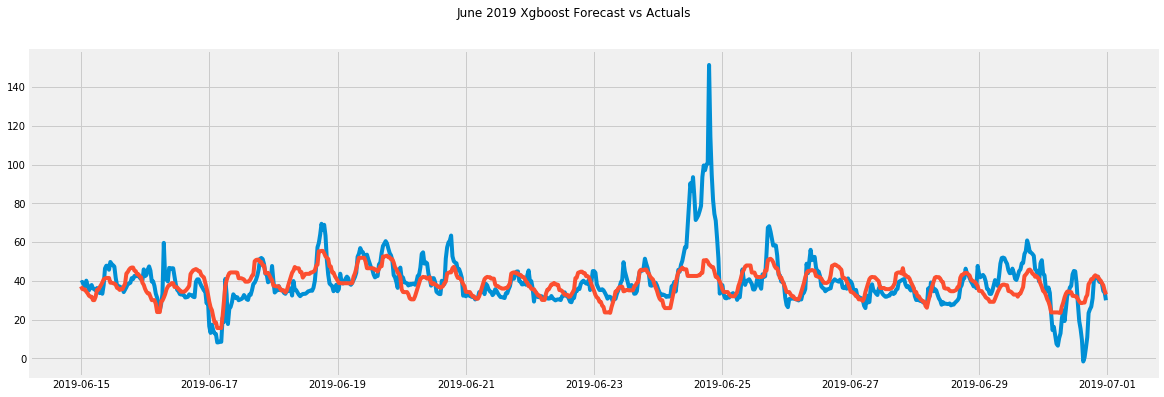

In [35]:
plt.figure(figsize=(18,6))
#plt.plot(pd.concat([train,test]))
plt.plot(test)
plt.plot(df_test.index, forecast_xgb, label='Xgboost')
plot = plt.suptitle('June 2019 Xgboost Forecast vs Actuals')

In [37]:
#Xgboost Model  evaluation:
from statsmodels.tools.eval_measures import mse,rmse
from sklearn.metrics import mean_absolute_error

error1 = mse(test, forecast_xgb)
error2 = rmse(test, forecast_xgb)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f'MAE Error: {mean_absolute_error(test, forecast_xgb)}'), 
print(f'MAPE Error: {mean_absolute_percentage_error(test, forecast_xgb)}')
print(f'MSE Error : {error1:11.10}')
print(f'RMSE Error: {error2:11.10}')
print()

MAE Error: 6.61998319854339
MAPE Error: 27.72045884588838
MSE Error : 110.5280509
RMSE Error: 10.51323218

